In [21]:
from os import path, makedirs, walk,listdir, remove
import pandas as pd
from shutil import copyfile
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Rescaling
from keras.backend import clear_session
from keras.utils import image_dataset_from_directory, split_dataset
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy, Precision, Recall, F1Score, TrueNegatives, TruePositives, FalseNegatives, FalsePositives
from keras.callbacks import EarlyStopping
from keras.regularizers import L2,L1
from random import choice

In [3]:
DATASET_NAMES = ('train','valid','test')
CLASS_DIRECTORY_NAMES = ('class_fracture','class_no_fracture')
DATASET_DIRECTORY = 'dataset'
TOP_DIRECTORY_CLASSIFIFICATIONS = path.join(DATASET_DIRECTORY ,'categorised_images')

#Hyperparameters
OPTIMIZER = Adam
LEARNING_RATE = 0.0001
LOSS_FUNCTION = BinaryCrossentropy
METRICS = [BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), F1Score(name='f1'), TrueNegatives(name='tn'), TruePositives(name='tp'), FalseNegatives(name='fn'), FalsePositives(name='fp')]
EPOCHS = 50
BATCH_SIZE = 10
VERBOSE = 1
REGULARIZER=L1
REGULARIZATION_FACTOR = 0.01
VALIDATION_SPLIT = 0.2
INPUT_SHAPE = (256,256,1)

In [4]:
def categorise_images(a_dataset_name):
    #creates a directory structure  like: images/
    #                                       class0/*.jpg
    #                                       class1/*.jpg
    #and copies the images into either leaf directory depending on their class label
    #this puts the data into a format that keras can load into a dataset

    fracture_directory = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, a_dataset_name,CLASS_DIRECTORY_NAMES[0])
    print('fracture_directory', fracture_directory)
    no_fracture_directory = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS,a_dataset_name,CLASS_DIRECTORY_NAMES[-1])
    print('no_fracture_directory', no_fracture_directory)

    if path.exists(fracture_directory) == False:  
        makedirs(fracture_directory) 
    if path.exists(no_fracture_directory) == False:  
        makedirs(no_fracture_directory) 

    #read labels into pandas df
    csv_filepath = path.join(DATASET_DIRECTORY, a_dataset_name, 'labels/labels.csv')
    print('csv_filepath', csv_filepath)
    df = pd.read_csv(path.join(csv_filepath))
    df = df.set_index('filename')

    #walk through files and copy file to relevant directory
    images_dir = path.join(DATASET_DIRECTORY,a_dataset_name,'images')
    print('images_dir', images_dir)
    filenames = []
    for (dirpath, dirnames, filenames) in walk(images_dir):
        filenames.extend(filenames)
 
    for filename in filenames:
        #ignore mac os system file
        if filename.endswith('.DS_Store'):
            pass
        elif df.loc[filename]['target'] == 1:
            destination = path.join(fracture_directory, filename)
        else:
            destination = path.join(no_fracture_directory, filename)
        source = path.join(images_dir, filename)
        copyfile(source, destination)

In [4]:
for dataset_name in DATASET_NAMES:
    categorise_images(dataset_name)

fracture_directory dataset/categorised_images/train/class_fracture
no_fracture_directory dataset/categorised_images/train/class_no_fracture
csv_filepath dataset/train/labels/labels.csv
images_dir dataset/train/images
fracture_directory dataset/categorised_images/valid/class_fracture
no_fracture_directory dataset/categorised_images/valid/class_no_fracture
csv_filepath dataset/valid/labels/labels.csv
images_dir dataset/valid/images
fracture_directory dataset/categorised_images/test/class_fracture
no_fracture_directory dataset/categorised_images/test/class_no_fracture
csv_filepath dataset/test/labels/labels.csv
images_dir dataset/test/images


In [5]:
#remove any non-jpg files in the directories
def find_and_remove_non_jpg_files(a_folder_path):
    #removes any non-jpg files in the provided directory
    num_skipped = 0
    for fname in listdir(a_folder_path):
        fpath = path.join(a_folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            print('removing non-image file: ' + fpath)
            remove(fpath)

    print(f"Deleted {num_skipped} files.")

In [6]:
#remove any non-processable files from the image directories
folders_checked = 0
for dataset_name in DATASET_NAMES:
    for class_dir_name in CLASS_DIRECTORY_NAMES:
        folder_path = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, dataset_name,class_dir_name)
        print('checking folder: '+folder_path)
        find_and_remove_non_jpg_files(folder_path)
        folders_checked +=1
print('checked', folders_checked, 'folders')

checking folder: dataset/categorised_images/train/class_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/train/class_no_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/valid/class_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/valid/class_no_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/test/class_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/test/class_no_fracture
Deleted 0 files.
checked 6 folders


In [7]:
def load_images(dataset_name):
    
    return image_dataset_from_directory(
    directory= path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, dataset_name),
    labels='inferred',
    label_mode="binary",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False
)

In [8]:
#Load the images into datasets
train_ds= load_images('train')
test_ds = load_images('test')
valid_ds = load_images('valid')
print('train_ds', train_ds.cardinality())
print('test_ds', test_ds.cardinality())
print('valid_ds', valid_ds.cardinality())

#create a combined dataset so the data can be shuffled and then split into training and test sets
combined_ds = train_ds.concatenate(valid_ds).concatenate(test_ds)
print('combined_ds', combined_ds.cardinality())

#shuffle and split the combined dataset with an 80/20 train/test split
#shuffled_train_ds, shuffled_test_ds = split_dataset(combined_ds, left_size=0.8, shuffle=True, seed=42)
#print('shuffled_train_ds', shuffled_train_ds.cardinality())
#print('shuffled_test_ds', shuffled_test_ds.cardinality())

Found 3631 files belonging to 2 classes.
Found 169 files belonging to 2 classes.
Found 348 files belonging to 2 classes.
train_ds tf.Tensor(364, shape=(), dtype=int64)
test_ds tf.Tensor(17, shape=(), dtype=int64)
valid_ds tf.Tensor(35, shape=(), dtype=int64)
combined_ds tf.Tensor(416, shape=(), dtype=int64)


In [9]:
combined_images = []
combined_labels = []
for images, labels in combined_ds.as_numpy_iterator():
    combined_images.extend(images)
    combined_labels.extend(labels)
combined_images = np.array(combined_images)
combined_labels = np.array(combined_labels)

X_train, X_test, y_train, y_test = train_test_split(combined_images, combined_labels, test_size=0.2, random_state=42)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

2024-03-24 22:45:32.548487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X_train (3318, 256, 256, 1)
X_test (830, 256, 256, 1)
y_train (3318, 1)
y_test (830, 1)


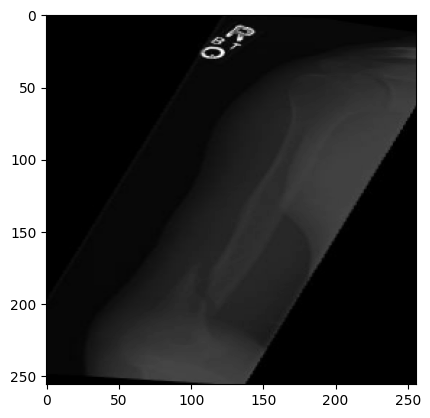

In [10]:
random_training_image = choice(X_train)
plt.imshow(random_training_image, cmap='gray')
plt.show()

In [11]:
def create_model(input_shape):

    #create a Sequential  model
    model = Sequential()

    #Add the layers
    model.add(Input(input_shape))
    model.add(Rescaling(1.0 / 255))
    #Add 2 convolutional layers paired with max pooling layers
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    #Flatten the output so that it can be processed as a Vector by the subsequent Dense layer
    model.add(Flatten())
    #if using a regularizer, instantiate it with the regularization factor
    if REGULARIZER is not None:
        the_regularizer = REGULARIZER(REGULARIZATION_FACTOR)
    else:
        the_regularizer = REGULARIZER
    #add a fully connected layer with  256 neurons and a relu activation function outut shape = 64
    model.add(Dense(256, kernel_regularizer=the_regularizer, activation='relu'))
    #add output layer with a single neuron and a sigmoind activation to represent the binary classification
    model.add(Dense(1, kernel_regularizer=REGULARIZER, activation='sigmoid'))

    return model

In [12]:
model = create_model(INPUT_SHAPE)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    58,982,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,352,577 (226.41 MB)

 Trainable params: 59,352,577 (226.41 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
def train_model(X_train, y_train):
    
    callbacks = [EarlyStopping(monitor='val_accuracy', patience=5, verbose=VERBOSE, restore_best_weights=True)]
    
    model = create_model(INPUT_SHAPE)
    model.compile(optimizer=OPTIMIZER(LEARNING_RATE), loss=LOSS_FUNCTION(), metrics=METRICS)
    model_history = model.fit(
                            X_train, y_train,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_split=VALIDATION_SPLIT,
                            verbose=VERBOSE,
                            callbacks=[callbacks])
    clear_session()

    return (model, model_history)

In [17]:
model, model_history = train_model(X_train, y_train)

Epoch 1/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 239s 891ms/step - accuracy: 0.4922 - f1: 0.6638 - fn: 912.7266 - fp: 102.9888 - loss: 359.8446 - precision: 0.4424 - recall: 0.0867 - tn: 905.5805 - tp: 82.6217 - val_accuracy: 0.4895 - val_f1: 0.6760 - val_fn: 339.0000 - val_fp: 0.0000e+00 - val_loss: 7.8919 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 325.0000 - val_tp: 0.0000e+00
Epoch 2/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 241s 906ms/step - accuracy: 0.4973 - f1: 0.6681 - fn: 556.2584 - fp: 113.1573 - loss: 7.8359 - precision: 0.4892 - recall: 0.1835 - tn: 558.1161 - tp: 112.3858 - val_accuracy: 0.4895 - val_f1: 0.6760 - val_fn: 339.0000 - val_fp: 0.0000e+00 - val_loss: 7.7721 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 325.0000 - val_tp: 0.0000e+00
Epoch 3/50
266/266 ━━━━━━━━━━━━━━━━━━━━ 241s 905ms/step - accuracy: 0.5132 - f1: 0.6590 - fn: 657.1685 - fp: 1.8764 - loss: 7.7557 - precision: 0.7237 - recall: 0.0136 - tn: 675.9401 - tp: 4.9326 - val_accuracy: 0.4

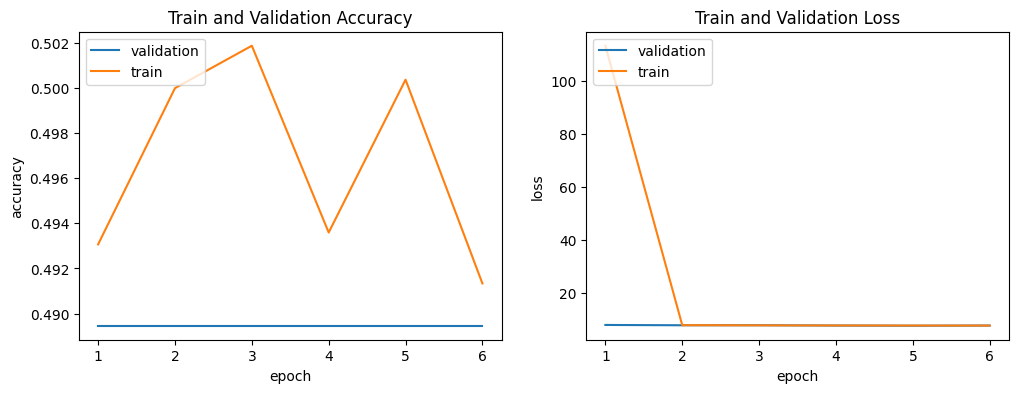

In [18]:
#plot the model accuracy and loss
epochs = len(model_history.history['accuracy'])
train_accuracy = model_history.history['accuracy']
valid_accuracy = model_history.history['val_accuracy']
train_loss = model_history.history['loss']
valid_loss = model_history.history['val_loss']

fig, (accuracy, loss) = plt.subplots(1, 2, sharex=True, sharey=False)
fig.set_size_inches(12,4 )
accuracy.plot(range(1, epochs+1), valid_accuracy) 
accuracy.plot(range(1, epochs+1), train_accuracy)  
accuracy.set_ylabel('accuracy')
accuracy.set_xlabel('epoch')
accuracy.legend(['validation','train'], loc='upper left')
accuracy.set_title('Train and Validation Accuracy')

loss.plot(range(1, epochs+1), valid_loss)
loss.plot(range(1, epochs+1), train_loss)
loss.set_ylabel('loss')
loss.set_xlabel('epoch')
loss.legend(['validation', 'train'], loc='upper left')
loss.set_title('Train and Validation Loss')

plt.show()

In [19]:
results  = model.evaluate(X_test, y_test)
print('accuracy', results[1])
print('loss', results[0])
print('precision', results[2])
print('recall', results[3])
print('f1', results[4])
print('tn', results[5])
print('tp', results[6])
print('fn', results[7])
print('fp', results[8])

26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 568ms/step - accuracy: 0.4877 - f1: 0.6774 - fn: 228.2222 - fp: 0.0000e+00 - loss: 7.8919 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 218.4444 - tp: 0.0000e+00
accuracy 0.49036145210266113
loss 7.891865253448486
precision 0.6751794815063477
recall 423.0
f1 0.0
tn 0.0
tp 0.0
fn 407.0
fp 0.0


In [23]:
predictions = model.predict(X_test)
#matrix = confusion_matrix(y_test, model.predict(X_test))

26/26 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step


In [24]:
predictions

array([[0.49956203],
       [0.49946854],
       [0.49942756],
       [0.49953103],
       [0.49968225],
       [0.49963167],
       [0.49955398],
       [0.49960184],
       [0.49962255],
       [0.49958566],
       [0.49953222],
       [0.4996047 ],
       [0.49962226],
       [0.49941438],
       [0.49933976],
       [0.49935457],
       [0.49960822],
       [0.49964967],
       [0.49969646],
       [0.49964693],
       [0.49938345],
       [0.4995579 ],
       [0.49966913],
       [0.49959147],
       [0.49957296],
       [0.49952453],
       [0.4994786 ],
       [0.4995358 ],
       [0.4995342 ],
       [0.4994741 ],
       [0.49922067],
       [0.49955136],
       [0.49953547],
       [0.49962497],
       [0.49950314],
       [0.49968565],
       [0.49955073],
       [0.49966285],
       [0.49937904],
       [0.4992662 ],
       [0.49967867],
       [0.49952483],
       [0.49958226],
       [0.4995569 ],
       [0.49951336],
       [0.49938786],
       [0.49945918],
       [0.499

In [ ]:
import datetime
print("Last modified: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S") + "\n")